In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **Imports**

In [0]:
import numpy as np
import pandas as pd
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import operator
from keras.models import Sequential, Model 
from keras.layers.embeddings import Embedding
from keras.layers import Flatten, Dense, Dropout, Convolution1D, MaxPooling1D, SpatialDropout1D, Input
from keras.layers import GlobalMaxPooling1D, concatenate, LSTM, Bidirectional, RepeatVector , GRU , Reshape
from keras.optimizers import Adam , Nadam
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
#from keras.callbacks import ModelCheckpoint

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Explore a pretarained Glove model**

We will use a pretrained Glove model for word embedding

In [0]:
embeddings_dictionary = dict()
glove_file = open('/content/gdrive/My Drive/glove.6B.100d.txt', encoding="utf8")
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions

glove_file.close()
len(embeddings_dictionary)

400000

Loading data

In [0]:
from google.colab import files
uploaded = files.upload()


Saving elonmusk_tweets.csv to elonmusk_tweets (4).csv
Saving Tweets_by_DonaldTrump_.csv to Tweets_by_DonaldTrump_ (4).csv


In [0]:
df=pd.read_csv('elonmusk_tweets (4).csv')
df_donald=pd.read_csv('Tweets_by_DonaldTrump_ (4).csv')
df.head()

,id,created_at,text
0,849636868052275200,2017-04-05 14:56:29,b'And so the robots spared humanity ... https:...
1,848988730585096192,2017-04-03 20:01:01,"b""@ForIn2020 @waltmossberg @mims @defcon_5 Exa..."
2,848943072423497728,2017-04-03 16:59:35,"b'@waltmossberg @mims @defcon_5 Et tu, Walt?'"
3,848935705057280001,2017-04-03 16:30:19,b'Stormy weather in Shortville ...'
4,848416049573658624,2017-04-02 06:05:23,"b""@DaveLeeBBC @verge Coal is dying due to nat ..."


In [0]:
#df_donald.head()

# **Data cleaning Part1**

In [0]:

#from sklearn.base import BaseEstimator, TransformerMixin

class TextCleaner():#BaseEstimator, TransformerMixin): 

    def unicode_to_ascii(self,text): #to fixe special caracters

      TEXT = (text.
    		replace('\\xe2\\x80\\x99', "'").
            replace('\\xc3\\xa9', 'e').
            replace('\\xe2\\x80\\x90', '-').
            replace('\\xe2\\x80\\x91', '-').
            replace('\\xe2\\x80\\x92', '-').
            replace('\\xe2\\x80\\x93', '-').
            replace('\\xe2\\x80\\x94', '-').
            replace('\\xe2\\x80\\x94', '-').
            replace('\\xe2\\x80\\x98', "'").
            replace('\\xe2\\x80\\x9b', "'").
            replace('\\xe2\\x80\\x9c', '"').
            replace('\\xe2\\x80\\x9c', '"').
            replace('\\xe2\\x80\\x9d', '"').
            replace('\\xe2\\x80\\x9e', '"').
            replace('\\xe2\\x80\\x9f', '"').
            replace('\\xe2\\x80\\xa6', '...').#
            replace('\\xe2\\x80\\xb2', "'").
            replace('\\xe2\\x80\\xb3', "'").
            replace('\\xe2\\x80\\xb4', "'").
            replace('\\xe2\\x80\\xb5', "'").
            replace('\\xe2\\x80\\xb6', "'").
            replace('\\xe2\\x80\\xb7', "'").
            replace('\\xe2\\x81\\xba', "+").
            replace('\\xe2\\x81\\xbb', "-").
            replace('\\xe2\\x81\\xbc', "=").
            replace('\\xe2\\x81\\xbd', "(").
            replace('\\xe2\\x81\\xbe', ")")

                 )
      return TEXT

    def remove_first(self,text):
         return re.sub("b'|b\"",'',text)

    def remove_mentions(self, text):        
        return re.sub(r'@\w+', '', text)
    
    def remove_urls(self, text):        
        return re.sub(r'http.?://[^\s]+[\s]?', '', text)
    
    def only_characters(self, text):
        return re.sub('[^a-zA-Z\s]', '', text)
    
    def remove_extra_spaces(self, text):
        text = re.sub("\s+", ' ', text)
        text = text.lstrip()
        return text.rstrip()
    
    def to_lower(self, text):
        return text.lower()
    
    def fix_words(self, text): # to fixe abbreviations
        text = re.sub(r'\bthx\b', 'thanks', text)
        text = re.sub(r'\bive\b', 'i have', text)
        text = re.sub(r'\bweve\b', 'we have', text)
        text = re.sub(r'\byouve\b', 'you have', text)
        text = re.sub(r'\bu\b', 'you', text)
        text = re.sub(r'\bur\b', 'your', text)
        text = re.sub(r'\br\b', 'are', text)
        text = re.sub(r'\bppl\b', 'people', text)
        text = re.sub(r'\bplz\b', 'please', text)
        text = re.sub(r'\btmrw\b', 'tomorrow', text)
        text = re.sub(r'\byall\b', 'you all', text)
        text = re.sub(r'\basap\b', 'as soon as possible', text)
        text = re.sub(r'\bbtw\b', 'by the way', text)
        text = re.sub(r'\btv\b', 'television', text)
        text = re.sub(r'\bokay\b', 'ok', text)
        text = re.sub(r'\byr\b', 'year', text)
        text = re.sub(r'\bshes\b', 'she is', text)
        text = re.sub(r'\bnope\b', 'no', text)
        text = re.sub(r'\bhes\b', 'he is', text)
        text = re.sub(r'\bomg\b', 'oh my god', text)
        text = re.sub(r'\bnothappy\b', 'not happy', text)
        return re.sub(r'\bthankyou\b', 'thank you', text)
    
    def transform(self, X):        
        clean_X = X.apply(self.unicode_to_ascii).apply(self.remove_first).apply(self.remove_mentions).apply(self.remove_urls).apply(self.only_characters).apply(self.remove_extra_spaces).apply(self.to_lower).apply(self.fix_words)
        return clean_X

In [0]:

ct = TextCleaner()
df['clean_text'] = ct.transform(df['text'])
#df_donald['clean_text']=ct.transform(df_donald['Tweet'])

In [0]:
df[['text','clean_text']]

,text,clean_text
0,b'And so the robots spared humanity ... https:...,and so the robots spared humanity
1,"b""@ForIn2020 @waltmossberg @mims @defcon_5 Exa...",exactly tesla is absurdly overvalued if based ...
2,"b'@waltmossberg @mims @defcon_5 Et tu, Walt?'",et tu walt
3,b'Stormy weather in Shortville ...',stormy weather in shortville
4,"b""@DaveLeeBBC @verge Coal is dying due to nat ...",coal is dying due to nat gas fracking its basi...
...,...,...
2814,b'That was a total non sequitur btw',that was a total non sequitur by the way
2815,"b'Great Voltaire quote, arguably better than T...",great voltaire quote arguably better than twai...
2816,b'I made the volume on the Model S http://t.co...,i made the volume on the model s go to now i j...
2817,"b""Went to Iceland on Sat to ride bumper cars o...",went to iceland on sat to ride bumper cars on ...


In [0]:
#df_donald[['Tweet','clean_text']]

In [0]:
def tokenize(s): 
    return s.split()
    
stop = set(stopwords.words('english'))
stop.update(['amp', 'rt', 'cc','cm','hr','pm','x','v','w','xexx','xfxfxxd','xexdxaxefxbxf'])
#stop = stop - set(['no', 'not'])


def remove_stopwords(row):
    return ' '.join(map(str,[t for t in row if t not in stop]))


In [0]:
df['tokenized'] = df['clean_text'].map(tokenize).map(remove_stopwords)
#df_donald['tokenized'] = df_donald['clean_text'].map(tokenize).map(remove_stopwords)


In [0]:
def remove_words_not_in_Glove(row): # keeps only words within Glove corpus
  return ' '.join(map(str,[t for t in row if t  in embeddings_dictionary.keys()]))

In [0]:
df['tokenized'] = df['tokenized'].map(tokenize).map(remove_words_not_in_Glove)

In [0]:
df.tokenized

0                                  robots spared humanity
1       exactly tesla absurdly overvalued based past t...
2                                              et tu walt
3                                          stormy weather
4          coal dying due nat gas fracking basically dead
                              ...                        
2814                               total non sequitur way
2815    great voltaire quote arguably better twain hea...
2816    made volume model go need work miniature stone...
2817    went iceland sat ride bumper cars ice country ...
2818    please ignore prior tweets someone pretending ...
Name: tokenized, Length: 2819, dtype: object

In [0]:
#df_donald.tokenized

In [0]:
df['length']=df['tokenized'].apply(lambda row: len(row.split()))
#df_donald['length']=df_donald['tokenized'].apply(lambda row: len(row.split()))

In [0]:
df['length'].value_counts()

10    249
8     246
9     246
11    225
7     224
12    188
1     180
4     176
2     173
6     172
13    162
5     155
3     152
14    119
15     58
0      44
16     28
17     12
18      8
19      2
Name: length, dtype: int64

In [0]:
#df_donald['length'].value_counts()

# **Create Word2Vec Model based on vocabulary in elunmusk_tweet and Donald_trump tweets** 
(to use it later for words representation)

Creating Vocabulary

In [0]:
Vocab=[]
for tweet in df['tokenized']:
  Vocab=Vocab+tweet.split()
for tweet in df_donald['tokenized']:
  Vocab=Vocab+tweet.split()
print(len(Vocab))
len(list(set(Vocab)))

56979


9329

Creating W2V corpus 

In [0]:
Corpus_W2V=[]
for tweet in df['tokenized']:
  Corpus_W2V.append(tweet.split())
for tweet in df_donald['tokenized']:
  Corpus_W2V.append(tweet.split())

Corpus_W2V


In [0]:
len(Corpus_W2V), len(df_donald['tokenized'])+len(df['tokenized'])

(4433, 4433)

In [0]:
Model_W2V = Word2Vec(Corpus_W2V, size=100, window=5, min_count=1, sg=1,iter=20)


In [0]:
print(len(Model_W2V.wv.vocab))
print(Model_W2V.wv.similarity('women','man'))
print(Model_W2V.wv.similarity('congressman','congress'))
print(Model_W2V.wv.similarity('robots','machines'))
print(Model_W2V.wv.similarity('women','machine'))
print(Model_W2V.wv.similarity('robots','humanity'))


9329
0.49085754
0.6992363
0.9784548
0.2614162
0.8259635


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


PCA to plot word distribution in 2 dimension

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


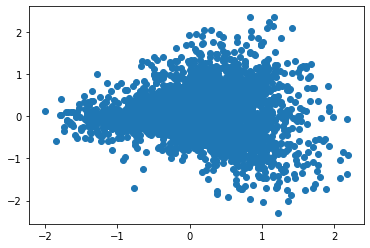

In [0]:
X = Model_W2V[Model_W2V.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
#words = list(Model_W2V.wv.vocab)
#for i, word in enumerate(words):
	#pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

In [0]:
Model_W2V.save('/content/gdrive/My Drive/W2V.bin')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
#model=Word2Vec.load('/content/gdrive/My Drive/W2V.bin')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
len(model.wv.vocab)

9343

# **Data Cleaning Part 2**

remove rows with length < 3

In [0]:
df['length'][(df.length==0)|(df.length==1)|(df.length==2)]=np.nan 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
df['length'].value_counts()

10.0    249
8.0     246
9.0     246
11.0    225
7.0     224
12.0    188
4.0     176
6.0     172
13.0    162
5.0     155
3.0     152
14.0    119
15.0     58
16.0     28
17.0     12
18.0      8
19.0      2
Name: length, dtype: int64

In [0]:
df.length.isna().sum()

397

In [0]:
df=df.dropna()

In [0]:
df.shape

(2422, 6)

In [0]:
df

,id,created_at,text,clean_text,tokenized,length
0,849636868052275200,2017-04-05 14:56:29,b'And so the robots spared humanity ... https:...,and so the robots spared humanity,robots spared humanity,3.0
1,848988730585096192,2017-04-03 20:01:01,"b""@ForIn2020 @waltmossberg @mims @defcon_5 Exa...",exactly tesla is absurdly overvalued if based ...,exactly tesla absurdly overvalued based past t...,8.0
2,848943072423497728,2017-04-03 16:59:35,"b'@waltmossberg @mims @defcon_5 Et tu, Walt?'",et tu walt,et tu walt,3.0
4,848416049573658624,2017-04-02 06:05:23,"b""@DaveLeeBBC @verge Coal is dying due to nat ...",coal is dying due to nat gas fracking its basi...,coal dying due nat gas fracking basically dead,8.0
5,848415731502923777,2017-04-02 06:04:07,"b""@Lexxxzis It's just a helicopter in helicopt...",its just a helicopter in helicopters clothing,helicopter helicopters clothing,3.0
...,...,...,...,...,...,...
2814,142881284019060736,2011-12-03 08:22:07,b'That was a total non sequitur btw',that was a total non sequitur by the way,total non sequitur way,4.0
2815,142880871391838208,2011-12-03 08:20:28,"b'Great Voltaire quote, arguably better than T...",great voltaire quote arguably better than twai...,great voltaire quote arguably better twain hea...,14.0
2816,142188458125963264,2011-12-01 10:29:04,b'I made the volume on the Model S http://t.co...,i made the volume on the model s go to now i j...,made volume model go need work miniature stone...,8.0
2817,142179928203460608,2011-12-01 09:55:11,"b""Went to Iceland on Sat to ride bumper cars o...",went to iceland on sat to ride bumper cars on ...,went iceland sat ride bumper cars ice country ...,14.0


Create corpus and vocabulary to use them in **TF-IDF** transformation

In [0]:
corpus=list(df.tokenized)

In [0]:
len(corpus)

2422

In [0]:
vocabulary = set()
for tweet in corpus:
    vocabulary.update(tweet.split())
 
vocabulary = list(vocabulary)

In [0]:
len(vocabulary)

5458

In [0]:
tfidf = TfidfVectorizer(vocabulary=vocabulary,ngram_range=(1, 2))
 
tfidf.fit(corpus)
tfidf.transform(corpus)

<2422x5458 sparse matrix of type '<class 'numpy.float64'>'
	with 20956 stored elements in Compressed Sparse Row format>

Create a function to determine the 3 most important words for each tweet

In [0]:
def most_important(doc):
    score={}
    X = tfidf.transform([doc])
    for word in doc.split():
        score[word] = X[0, tfidf.vocabulary_[word]]
    sortedscore = sorted(score.items(), key=operator.itemgetter(1), reverse=True)
    return list(t[0] for t in sortedscore[:3])

In [0]:
most_important(df.tokenized[0])

['spared', 'robots', 'humanity']

In [0]:
df['important_words']=df['tokenized'].map(most_important)

In [0]:
df.important_words

0                [spared, robots, humanity]
1               [absurdly, overvalued, irr]
2                            [tu, walt, et]
4                    [nat, fracking, dying]
5       [helicopters, clothing, helicopter]
                       ...                 
2814                 [sequitur, total, non]
2815             [voltaire, twain, replied]
2816        [stonehenge, miniature, volume]
2817                [iceland, bumper, rink]
2818           [ignore, pretending, tweets]
Name: important_words, Length: 2422, dtype: object

Transform words to their ids for further uses

In [0]:
w2id = {w: idx for idx, w in enumerate(vocabulary)}
w2id['unk']=-1

def transform_to_ids(row):
    return [w2id[w] if w in w2id.keys() else -1 for w in row]
df['tokenized_int'] = df['important_words'].apply(lambda x: transform_to_ids(x))


In [0]:
df.tokenized_int

0       [1347, 3780, 3475]
1         [1004, 35, 2406]
2       [5377, 1572, 4050]
4        [5145, 2404, 441]
5       [4191, 3096, 2382]
               ...        
2814    [2992, 2819, 1025]
2815    [3255, 2703, 2776]
2816     [4346, 565, 2358]
2817    [4988, 4044, 1298]
2818    [1695, 1308, 5085]
Name: tokenized_int, Length: 2422, dtype: object

In [0]:
df['len_important_words']=df['important_words'].apply(lambda x:len(x))

Create a new_df that contains only tweets length > 3 after the whole process of cleaning

In [0]:

new_df=df[df.len_important_words>2]

In [0]:
new_df

,id,created_at,text,clean_text,tokenized,length,important_words,tokenized_int,len_important_words
0,849636868052275200,2017-04-05 14:56:29,b'And so the robots spared humanity ... https:...,and so the robots spared humanity,robots spared humanity,3.0,"[spared, robots, humanity]","[1347, 3780, 3475]",3
1,848988730585096192,2017-04-03 20:01:01,"b""@ForIn2020 @waltmossberg @mims @defcon_5 Exa...",exactly tesla is absurdly overvalued if based ...,exactly tesla absurdly overvalued based past t...,8.0,"[absurdly, overvalued, irr]","[1004, 35, 2406]",3
2,848943072423497728,2017-04-03 16:59:35,"b'@waltmossberg @mims @defcon_5 Et tu, Walt?'",et tu walt,et tu walt,3.0,"[tu, walt, et]","[5377, 1572, 4050]",3
4,848416049573658624,2017-04-02 06:05:23,"b""@DaveLeeBBC @verge Coal is dying due to nat ...",coal is dying due to nat gas fracking its basi...,coal dying due nat gas fracking basically dead,8.0,"[nat, fracking, dying]","[5145, 2404, 441]",3
5,848415731502923777,2017-04-02 06:04:07,"b""@Lexxxzis It's just a helicopter in helicopt...",its just a helicopter in helicopters clothing,helicopter helicopters clothing,3.0,"[helicopters, clothing, helicopter]","[4191, 3096, 2382]",3
...,...,...,...,...,...,...,...,...,...
2814,142881284019060736,2011-12-03 08:22:07,b'That was a total non sequitur btw',that was a total non sequitur by the way,total non sequitur way,4.0,"[sequitur, total, non]","[2992, 2819, 1025]",3
2815,142880871391838208,2011-12-03 08:20:28,"b'Great Voltaire quote, arguably better than T...",great voltaire quote arguably better than twai...,great voltaire quote arguably better twain hea...,14.0,"[voltaire, twain, replied]","[3255, 2703, 2776]",3
2816,142188458125963264,2011-12-01 10:29:04,b'I made the volume on the Model S http://t.co...,i made the volume on the model s go to now i j...,made volume model go need work miniature stone...,8.0,"[stonehenge, miniature, volume]","[4346, 565, 2358]",3
2817,142179928203460608,2011-12-01 09:55:11,"b""Went to Iceland on Sat to ride bumper cars o...",went to iceland on sat to ride bumper cars on ...,went iceland sat ride bumper cars ice country ...,14.0,"[iceland, bumper, rink]","[4988, 4044, 1298]",3


# **Create a column with W2V represention**

In [0]:
len(model['robots'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


100

In [0]:
def word_vec(l):
  return ([model[word] for word in l ])

In [0]:
new_df['tokenized_w2v']=new_df['important_words'].map(word_vec)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
len(new_df['tokenized_int']) #, len(new_df['tokenized_w2v'])

2420

# **Create a column with Glove representation**

In [0]:
def word_glove(l):
  return ( [embeddings_dictionary[word] for word in l])

In [0]:
new_df['tokenized_Glove']=new_df['important_words'].map(word_glove)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
len(new_df['tokenized_Glove'])

2420

# **Create X and Y with Glove**

In [0]:
#create X
L=[]
for doc in new_df['tokenized_Glove']:

  L.append(doc)
print(len(L))
X=[]
l=[]
j=0
while(j < len(L)-3):
  for i in range(3):
      for b in L[j+i]:
        l.append(b)
  X.append(l)
  l=[]
  j=j+1
print(j)
#create Y
Y=L[3:]






2420
2417


In [0]:
len(X), len(Y)

(2417, 2417)

In [0]:
len(X[1]), len(Y[1])

(9, 3)

In [0]:
X=np.array(X)
Y=np.array(Y)

# **Building the model(tokenized_Glove)**

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)
X_train.shape, Y_train.shape , X_test.shape, Y_test.shape

((1812, 9, 100), (1812, 3, 100), (605, 9, 100), (605, 3, 100))

In [0]:
model = Sequential()
model.add(Convolution1D(256, 7, padding='same', activation='relu',kernel_initializer='normal'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dropout(0.2))
#model.add(Convolution1D(128, 3, padding='same', activation='relu',kernel_initializer='normal'))
#model.add(MaxPooling1D(3))
#model.add(Flatten())
#model.add(Dropout(0.2))
model.add(Dense(512, activation='relu',kernel_initializer='normal'))
model.add(Dropout(0.2))
model.add(Dense(3*100, activation='relu',kernel_initializer='normal'))
model.add(Dropout(0.2))
model.add(Reshape((3,100)))

model.compile(loss='mse', optimizer=Adam(), metrics=['accuracy'])
history=model.fit(X_train,Y_train,validation_data=(X_test,Y_test),batch_size=64,epochs=30,shuffle=True)

Train on 1812 samples, validate on 605 samples
Epoch 1/30
1812/1812 [==============================] - 3s 2ms/step - loss: 0.3170 - acc: 0.1902 - val_loss: 0.2759 - val_acc: 0.3504
Epoch 2/30
1812/1812 [==============================] - 1s 616us/step - loss: 0.2777 - acc: 0.2472 - val_loss: 0.2746 - val_acc: 0.3306
Epoch 3/30
1812/1812 [==============================] - 1s 601us/step - loss: 0.2759 - acc: 0.2472 - val_loss: 0.2724 - val_acc: 0.3080
Epoch 4/30
1812/1812 [==============================] - 1s 606us/step - loss: 0.2735 - acc: 0.2467 - val_loss: 0.2712 - val_acc: 0.3163
Epoch 5/30
1812/1812 [==============================] - 1s 616us/step - loss: 0.2718 - acc: 0.2653 - val_loss: 0.2708 - val_acc: 0.3300
Epoch 6/30
1812/1812 [==============================] - 1s 637us/step - loss: 0.2705 - acc: 0.2772 - val_loss: 0.2701 - val_acc: 0.3421
Epoch 7/30
1812/1812 [==============================] - 1s 624us/step - loss: 0.2697 - acc: 0.2712 - val_loss: 0.2699 - val_acc: 0.3207
Epo

In [0]:
loss,accuracy=model.evaluate(X_test,Y_test)
print('Accuracy: %f' % (accuracy*100))

605/605 [==============================] - 0s 188us/step
Accuracy: 28.429752


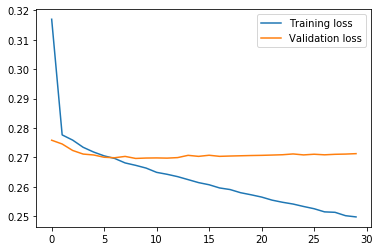

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure()
plt.plot( loss, label='Training loss')
plt.plot( val_loss, label='Validation loss')
plt.legend()
plt.show()

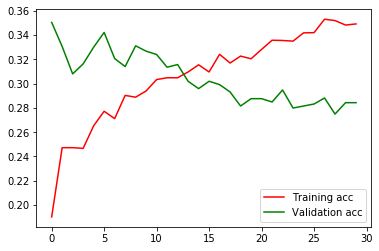

In [0]:

plt.figure()
plt.plot(history.history['acc'],'r',label='Training acc')
plt.plot(history.history['val_acc'],'g',label='Validation acc')
plt.legend()
plt.show()

# **Models avec W2V representation**

In [0]:
#create X
L=[]
for doc in new_df['tokenized_w2v']:

  L.append(doc)
print(len(L))
X=[]
l=[]
j=0
while(j < len(L)-3):
  for i in range(3):
      for b in L[j+i]:
        l.append(b)
  X.append(l)
  l=[]
  j=j+1
print(j)
#create Y
Y=L[3:]

In [0]:
X=np.array(X)
Y=np.array(Y)

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
X_train.shape, Y_train.shape , X_test.shape, Y_test.shape

((1691, 9, 100), (1691, 3, 100), (726, 9, 100), (726, 3, 100))

## **A model based on keras Dense Layer**

In [0]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(32, kernel_initializer='normal',input_shape = (X_train.shape[1],), activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(8, kernel_initializer='normal',activation='relu'))
#NN_model.add(Dense(512, kernel_initializer='normal',activation='relu'))
#NN_model.add(Dense(512, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(3*100, kernel_initializer='normal',activation='linear'))
NN_model.add(Reshape((3,100)))
# Compile the network :
NN_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [0]:
history=NN_model.fit(X_train,Y_train,validation_data=(X_test,Y_test), epochs=100, batch_size=32,shuffle=True)


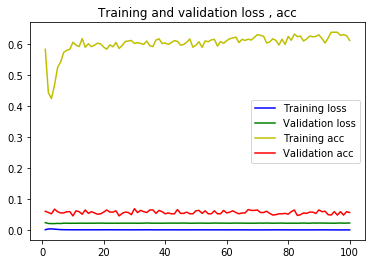

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc=history.history['acc']
val_acc=history.history['val_acc']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation loss , acc')
plt.legend()
plt.show()

## **A model based on keras LSTM layer**

In [0]:
regressor = Sequential()

regressor.add(LSTM(units = 256 ,input_shape = (X_train.shape[1], X_train.shape[-1]),activation='relu'))
#regressor.add(Dropout(0.2))

#regressor.add(LSTM(units = 512,activation='relu'))
#regressor.add(Dropout(0.2))

#regressor.add(LSTM(units = 512,return_sequences = True,activation='relu'))
#regressor.add(Dropout(0.2))

#regressor.add(LSTM(units = 512,activation='relu'))
#regressor.add(Dropout(0.2))

regressor.add(Dense(3*100,activation='linear'))
regressor.add(Reshape((3,100)))

regressor.compile(optimizer = 'adam', loss = 'mse', metrics=['accuracy'])

history=regressor.fit(X_train, Y_train, validation_data=(X_test,Y_test), epochs = 100, batch_size = 32)

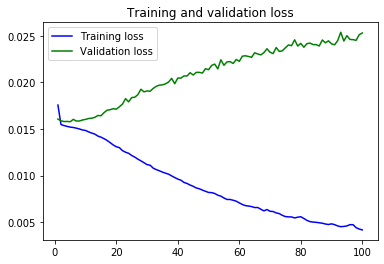

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

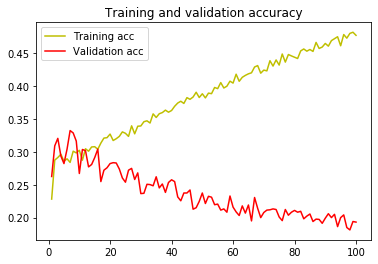

In [0]:
acc=history.history['acc']
val_acc=history.history['val_acc']
plt.figure()
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

# **Embedding layer trainning** 
(for word embedding builing without using W2V)

In [0]:
embedding_model=Sequential()
embedding_model.add(Embedding(input_dim=5868, output_dim=32, input_length=3))
embedding_model.compile('rmsprop', 'mse')

In [0]:
L_tensor=[np.array(l) for l in L]
tensor=np.array(L_tensor)
history=embedding_model.fit(L,L,epochs=10,batch_size=32)

In [0]:
from tensorflow.keras import layers
embedding_layer = layers.Embedding(5868, 32)
result = embedding_layer(tf.constant(L))
result

In [0]:
L_tensor=[np.array(l) for l in L]
tensor=np.array(L_tensor)
import tensorflow as tf
result=embedding_model(tf.constant(L))
result

In [0]:
result.shape

In [0]:
print(tf.constant(L))

In [0]:
result.numm

In [0]:
L

# **Autoencoders for word embedding**
(Determine words vectors by using autoencoders)


In [0]:
L_seq=pad_sequences(L,maxlen=3)

In [0]:
L_seq

array([[3157, 5811,   72],
       [5823, 2885, 3294],
       [5370, 3669, 3172],
       ...,
       [ 523, 3138, 4731],
       [  90, 2639,   56],
       [2887, 5012, 5789]], dtype=int32)

In [0]:

tokenizer = Tokenizer(num_words =5868, split=' ')
sentence = "here's a sample unseen sentence"
seq = tokenizer.texts_to_sequences([sentence])
pad_seq = pad_sequences(seq, 5)

In [0]:
pad_seq

array([[0, 0, 0, 0, 0]], dtype=int32)

In [0]:
#encoder
encoder_inputs = Input(shape=(3,), name='Encoder-Input')
emb_layer = Embedding(5868,150,input_length = 3, name='Body-Word-Embedding', mask_zero=False)

x = emb_layer(encoder_inputs)
state_h = LSTM(128, activation='relu', name='Encoder-Last-LSTM')(x)
encoder_model = Model(inputs=encoder_inputs, outputs=state_h, name='Encoder-Model')
seq2seq_encoder_out = encoder_model(encoder_inputs)

#decoder
decoded = RepeatVector(3)(seq2seq_encoder_out)
decoder_lstm = LSTM(128, return_sequences=True, name='Decoder-LSTM-before')
decoder_lstm_output = decoder_lstm(decoded)
decoder_dense = Dense(5868, activation='softmax', name='Final-Output-Dense-before')
decoder_outputs = decoder_dense(decoder_lstm_output)

#combined model
seq2seq_Model = Model(encoder_inputs, decoder_outputs)
seq2seq_Model.compile(Nadam(lr=0.001), loss='sparse_categorical_crossentropy')
history = seq2seq_Model.fit(L_seq,
          np.expand_dims(L_seq, -1),
          batch_size=16,
          epochs=50)

In [0]:
vecs = encoder_model.predict(L_seq)[0]
vecs

array([ 4.560351  ,  0.61853415,  0.        ,  4.926578  ,  0.6014459 ,
        0.        ,  0.        ,  0.04441418,  2.2463956 ,  2.8405104 ,
        0.57791585,  1.5956055 ,  0.57640356,  1.9738897 ,  4.158463  ,
        4.285515  ,  0.        ,  0.8391853 ,  0.        ,  0.2387438 ,
        0.        ,  7.0932865 ,  0.6622597 ,  4.0267806 , 11.845824  ,
        0.09744414, 10.22892   ,  1.2126017 ,  3.6742406 ,  6.9921393 ,
        0.9904526 ,  0.        ,  0.11802069,  0.1316043 ,  7.27034   ,
       12.180494  ,  2.1524053 ,  3.9857535 ,  1.1859989 ,  0.27791265,
        2.4792469 ,  1.6614366 ,  0.9773666 ,  0.        ,  0.33074242,
        2.718978  ,  0.        ,  4.698751  ,  4.8513613 ,  0.        ,
        0.01396563,  0.        ,  0.48151243, 11.559972  ,  5.3572645 ,
        0.        ,  1.9865744 ,  1.095119  ,  4.365117  ,  2.4277277 ,
        0.7231563 ,  0.49508888,  0.41887432,  1.4233055 ,  0.29491875,
        1.9005473 ,  0.23397616,  0.83505785,  3.5556371 ,  0.42

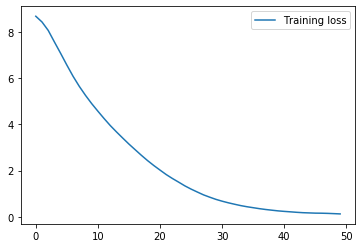

In [0]:
loss = history.history['loss']
#val_loss = history.history['val_loss']
plt.figure()
plt.plot( loss, label='Training loss')
#plt.plot( val_loss, label='Validation loss')
plt.legend()
plt.show()

# **Traying a model that starts with embedding layer**

In [0]:
#create X
L=[]
for doc in new_df['tokenized_int']:

  L.append(doc)
print(len(L))
X=[]
l=[]
j=0
while(j < len(L)-3):
  for i in range(3):
      for b in L[j+i]:
        l.append(b)
  X.append(l)
  l=[]
  j=j+1
print(j)
#create Y
Y=L[3:]

2420
2417


In [0]:
len(X),len(Y)

(2417, 2417)

## **Creating an embedding matrix**
(to pass it as weights in embedding layer)

In [0]:
embedding_matrix = np.zeros((len(vocabulary), 100))
for  index , word in enumerate(vocabulary) :
    embedding_vector = embeddings_dictionary[str(word)]
    if embedding_vector is not None:
        embedding_matrix[int(index)] = embedding_vector

In [0]:
model = Sequential()
embedding_layer = Embedding(len(vocabulary), 100, weights=[embedding_matrix], input_length=9, trainable=False)
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(3, activation='relu'))
model.compile(optimizer='adam', loss='mse', metrics=['acc'])
print(model.summary())

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 9, 100)            545800    
_________________________________________________________________
flatten_17 (Flatten)         (None, 900)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 3)                 2703      
Total params: 548,503
Trainable params: 2,703
Non-trainable params: 545,800
_________________________________________________________________
None


In [0]:
model.fit(X,Y, epochs=100,batch_size=64)

In [0]:
loss, accuracy = model.evaluate(padded_sentences, sentiments, verbose=0)
print('Accuracy: %f' % (accuracy*100))